In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from alibi_detect.cd import KSDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

In [3]:
def original_cifar_10_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    y_train = y_train.astype('int64').reshape(-1,)
    y_test = y_test.astype('int64').reshape(-1,)
    return X_train,X_test,y_train,y_test

In [4]:
X_train,X_test,y_train,y_test = original_cifar_10_data()  

In [5]:
# For CIFAR-10-C we can select from the following corruption types at 5 severity levels
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


In [6]:
# Picking a subset of the corruptions at corruption level 5
# Each Corruption type consists of pertubations on all of the original test set images
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [48]:
# my testing
my_arr = np.arange(1,51,1)
# print(my_arr)
idx = np.random.choice(len(my_arr),size=len(my_arr) // 2,replace=False)

res =np.arange(50)
res

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [7]:
# We split the original test set in a reference dataset and a dataset which should not be rejected under the H0 of the K-S test.
# We also split the corrupted data by corruption type:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [8]:
X_corr.shape

(40000, 32, 32, 3)

In [73]:
len(corruption)

4

In [9]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]  

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [15]:
print(X_test.shape)

(10000, 32, 32, 3)


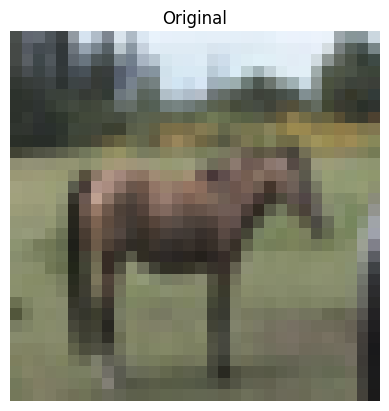

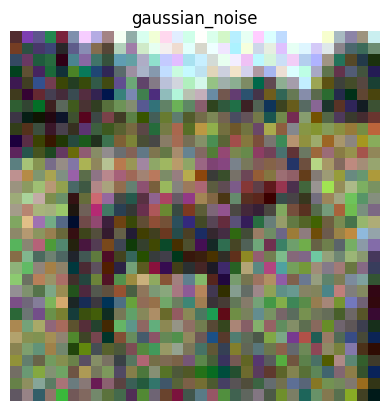

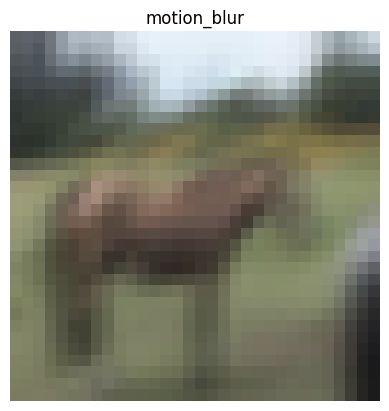

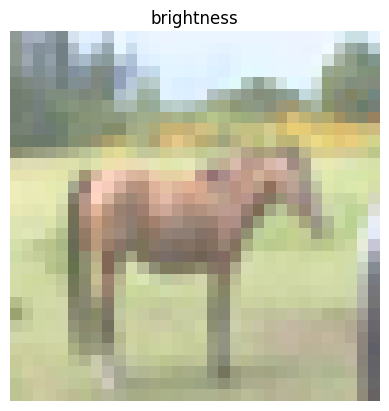

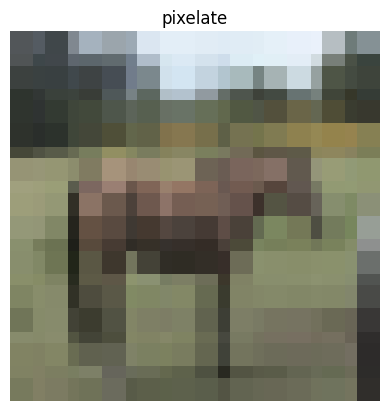

In [10]:
# We can visualise the same instance for each corruption type:

i = 9999

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

In [11]:
# We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

4293464/4293464 [==============================] - 0s 0us/step


2023-01-30 16:23:52.951866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-30 16:23:52.951912: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 16:23:52.951929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jingle): /proc/driver/nvidia/version does not exist
2023-01-30 16:23:52.952151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


In [12]:
# Random encoder (Untrained Auto Encoder)
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
p_val = .05
cd = KSDrift(X_ref, p_val=p_val, preprocess_fn=preprocess_fn)

# we can also save/load an initialised detector
filepath = '/home/jinglewsl/evoila/projects/image-drift-monitoring/src/modules/alibi_detect/ks_detector_cifar10'  # change to directory where detector is saved
save_detector(cd, filepath)

Directory /home/jinglewsl/evoila/projects/image-drift-monitoring/src/modules/alibi_detect/ks_detector_cifar10 does not exist and is now created.
Directory /home/jinglewsl/evoila/projects/image-drift-monitoring/src/modules/alibi_detect/ks_detector_cifar10/preprocess_fn/model does not exist and is now created.


In [13]:
# The p-value used by the detector for the multivariate data with encoding_dim features is equal to p_val / encoding_dim because of the Bonferroni correction
assert cd.p_val / cd.n_features == p_val / encoding_dim

In [14]:
#Let’s check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print(f'Time (s) {dt:.3f}')
    print(preds)
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print('Feature-wise p-values:')
            print(preds['data']['p_val'])
            print(f'Time (s) {dt:.3f}')

In [15]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
Feature-wise p-values:
[0.9386024  0.13979132 0.6384489  0.05413922 0.37460664 0.25598603
 0.87304014 0.47553554 0.11587767 0.67217577 0.47553554 0.7388285
 0.08215971 0.14635575 0.3114053  0.3114053  0.60482025 0.36134896
 0.8023182  0.21715216 0.24582714 0.46030036 0.11587767 0.44532147
 0.25598603 0.58811766 0.5550683  0.95480835 0.8598946  0.23597081
 0.8975547  0.68899393]
Time (s) 1.354
{'data': {'is_drift': 0, 'distance': array([0.0106, 0.023 , 0.0148, 0.0268, 0.0182, 0.0202, 0.0118, 0.0168,
       0.0238, 0.0144, 0.0168, 0.0136, 0.0252, 0.0228, 0.0192, 0.0192,
       0.0152, 0.0184, 0.0128, 0.021 , 0.0204, 0.017 , 0.0238, 0.0172,
       0.0202, 0.0154, 0.0158, 0.0102, 0.012 , 0.0206, 0.0114, 0.0142],
      dtype=float32), 'p_val': array([0.9386024 , 0.13979132, 0.6384489 , 0.05413922, 0.37460664,
       0.25598603, 0.87304014, 0.47553554, 0.11587767, 0.67217577,
       0.47553554, 0.7388285 , 0.08215971, 0.14635575, 0.3114053 ,
       0.3114053 , 0.6048

In [ ]:
for i in range(5):
    print(i)